I wrote this little notebook to look at the KMER spectra of whole genomes and sliding windows of genomes to determine if certain regions had been transfered horizontally. We have a gene of interest called Hap2 that we suspected was associate to mobile elements or 'mobilome' in archaea and bacteria. 

In [38]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import itertools
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from Bio import SeqIO


#here we generate all possible kmers of the specified length to make an index
#for the normalized spectra vectors
kmersize = 4
kmerindex = {''.join(k):i for i,k in enumerate(itertools.product('ACTG', repeat=kmersize))}



In this first cell I import a few libraries and generate the kmer index used in the rest of the analysis. Larger kmer will result in more resolution to distinguish the different fragements of DNA we will be analyzing but may not be appropriate for smaller fragments. In some of the sliding window analysis shown later and looking at the spectra of metagenomic scaffolds which a re quite short, the spectra tend to get quite noisy if I use larger kmer sizes.

In [39]:

def genstream(handle):
    for line in handle:
        if '>' not in line:
            for char in line.strip():
                yield char
                
def genkmers(charstream,kmersize):
    buff = []
    for char in charstream:
        if char in ['A', 'C', 'G', 'T']:
            if len(buff)<kmersize:
                buff.append(char)
            else:
                yield ''.join(buff)
                buff.pop(0)
                buff.append(char)
        if char == '>':
            buff = []

def histvec(histin, kmerindex):
    hist= np.zeros( len(kmerindex) )
    for kmer in genkmers(genstream(histin),kmersize):
            hist[kmerindex[kmer]]+=1
    hist /= np.sum(hist)
    return hist



In this first analysis I generate average spectra for genomes as well as spectra for our genes of interest. Each spectrum has a unique signature. These are visualized as square matrices where each entry in the matrix represents the proportion of each kmer found in the sequence analysed.

In [40]:
indices = []
values = []

allspectra = []
clusterlabels = []

histfiles = glob.glob('./*fna')

histfiles +=  glob.glob('./*fasta')

print(histfiles)


['./GCA_006452135.1_ASM645213v1_genomic.fna', './GCA_006452155.1_ASM645215v1_genomic.fna', './GCA_003336485.1_ASM333648v1_genomic.fna', './sequence arch.fasta', './sequence.fasta']


['./GCA_006452135.1_ASM645213v1_genomic.fna', './GCA_006452155.1_ASM645215v1_genomic.fna', './GCA_003336485.1_ASM333648v1_genomic.fna', './sequence arch.fasta', './sequence.fasta']
./GCA_006452135.1_ASM645213v1_genomic.fna


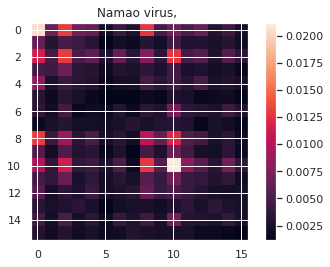

./GCA_006452155.1_ASM645215v1_genomic.fna


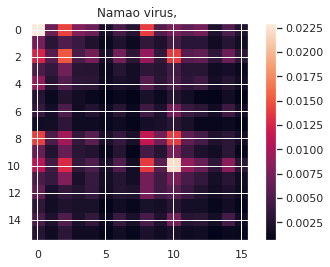

./GCA_003336485.1_ASM333648v1_genomic.fna


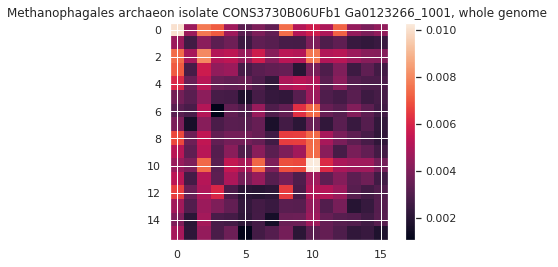

./sequence arch.fasta


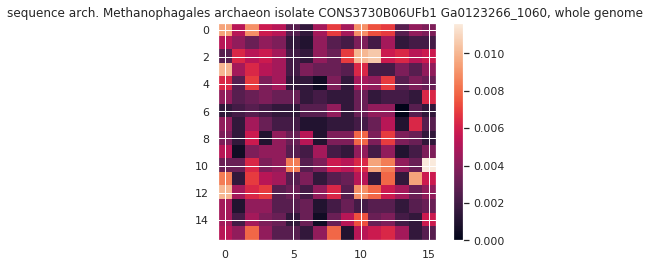

./sequence.fasta


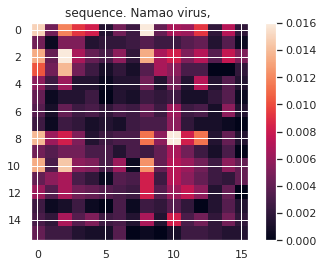

<Figure size 432x288 with 0 Axes>

In [41]:

print(histfiles)
for filename in histfiles:
    with open(filename , 'r') as histin:
        
        species = ''.join([ word + ' ' for word in next(histin).split()[1:-2] ])        
        if 'fna' in filename:
            label = species
        else:
            label = filename.split('/')[-1].replace('fasta','') + ' ' + species

        clusterlabels.append(label)
        print(filename)
        hist = histvec(histin, kmerindex)
        allspectra.append( hist )
        squaredim = int(np.sqrt(len(hist)))
        hist = hist.reshape((squaredim,squaredim))
        plt.imshow(hist)
        plt.title(label)
        plt.colorbar()
        #plt.show()

        plt.savefig(filename+'.svg')
        plt.show()
        plt.clf()


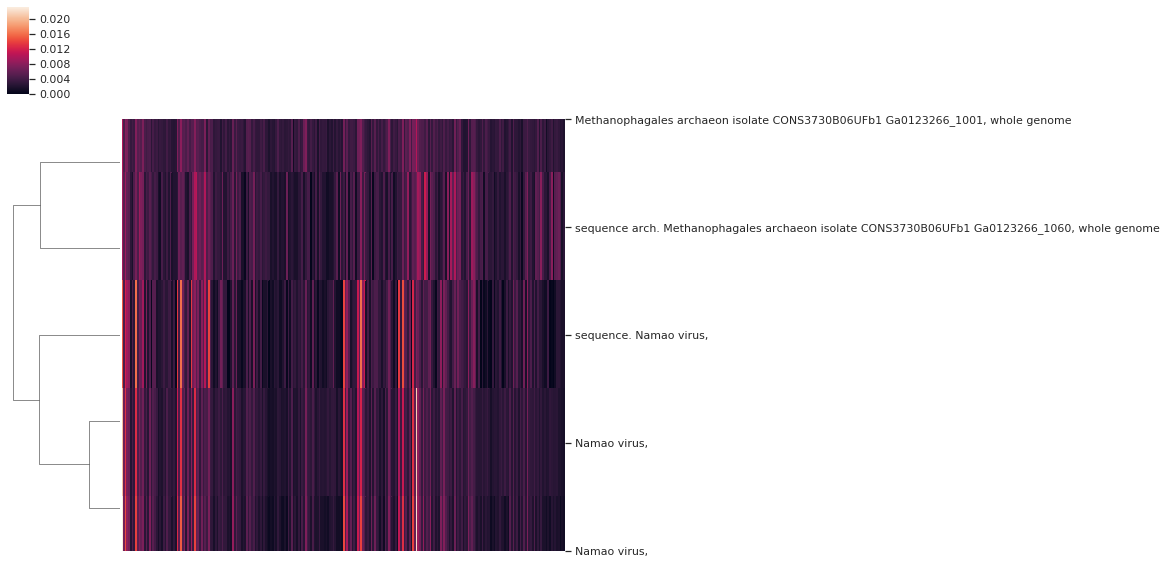

In [42]:


allspectranp = np.vstack(allspectra)
g = sns.clustermap(allspectranp, col_cluster=False, yticklabels = clusterlabels , xticklabels = [])#, figsize= (30,40))
g.savefig("kmer_tree.svg")


In addition to considering the average spectrum over an entire genome or one ORF, I looked at the deviation from the genomic average spectrum in a sliding window over the genome. This can help indicate which regions have spectra that deviate from the norm and provide clues as to which ORFS may have been transferred along with our gene of interest.

In [43]:
#find deviation from normal spectrum in windows of the genome

import math

def genomechop(genome , windowlen, steplen, yield_positions= False):
    count = 0
    for record in SeqIO.parse(genome, "fasta"):
        seqstr = str(record.seq)
        strbuff = ''
        if steplen > len(record.seq):
            yield count, record.seq
            count+= len(record.seq)
        else:
            for i in range(int(math.floor(len(record)/steplen))):
                seqwindow = str( record[steplen*i-int(windowlen/2): steplen*i+int(windowlen/2)].seq )
                yield count, seqwindow
                count += steplen

def genomeslice(genome ,positions , labels, slices , contig= None , verbose = True ):
    positions= dict(zip(labels,positions))
    for record in SeqIO.parse(genome, "fasta"):
        for sli in slices:
            if   sli[0] >= positions[str(record.id)] and sli[0] <= positions[str(record.id)] + len(record.seq):
                if len(record)<2000:
                    yield record
                
                start = sli[0] -positions[str(record.id)]
                stop = min( [len(record.seq) , sli[1]-positions[str(record.id) ] ])  
                if verbose == True:
                    print( (start, stop) ) 

                yield record[start:stop]

                    
def genometicks(genome):
    positions=[]
    labels=[]
    count=0
    for record in SeqIO.parse(genome, "fasta"):
        labels.append( str(record.id) )
        positions.append(count)
        count += len(record)    
    return positions,labels, count
 

>QENH01000144.1:10639-12534
>MG745875.1:64112-66052
./GCA_006452135.1_ASM645213v1_genomic.fna
MG745874.1 Namao virus, partial genome



/home/cactuskid/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


nan
['', '', '25kbp', '50kbp', '75kbp', '100kbp', '125kbp', '150kbp', '175kbp', '200kbp', '225kbp']
title
MG745874.1 Namao virus, partial genome



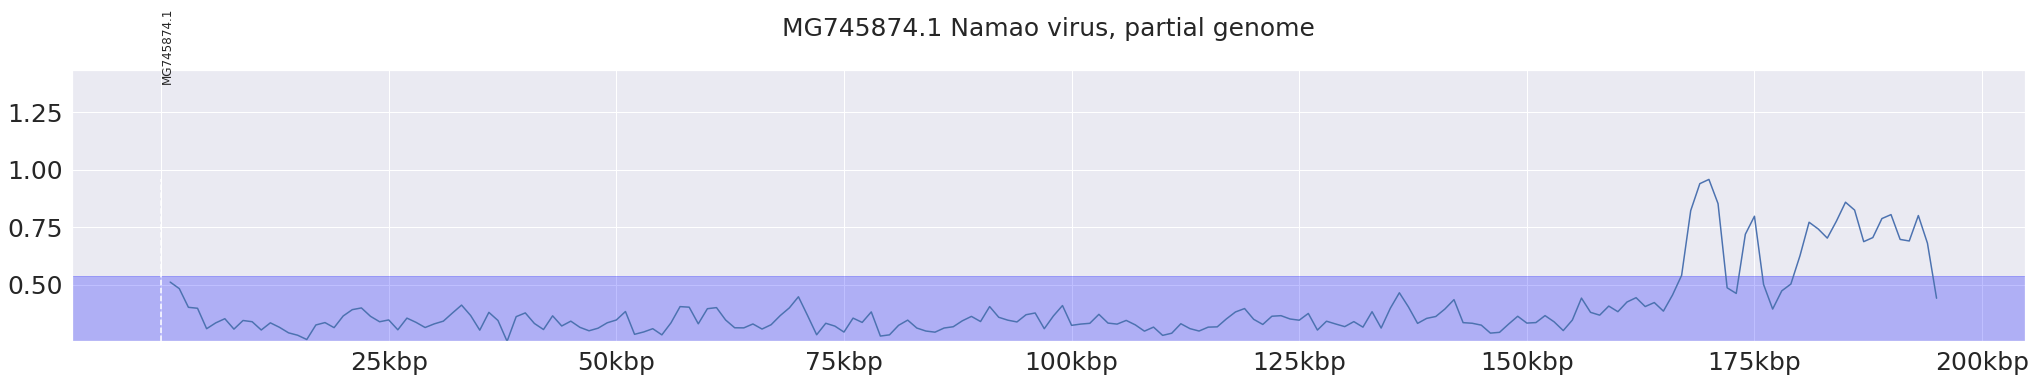

./GCA_006452155.1_ASM645215v1_genomic.fna
MG745875.1 Namao virus, partial genome

nan
['', '', '20kbp', '40kbp', '60kbp', '80kbp', '100kbp', '120kbp']
title
MG745875.1 Namao virus, partial genome

[(61612, 68552)]
(61612, 68552)
[6940]


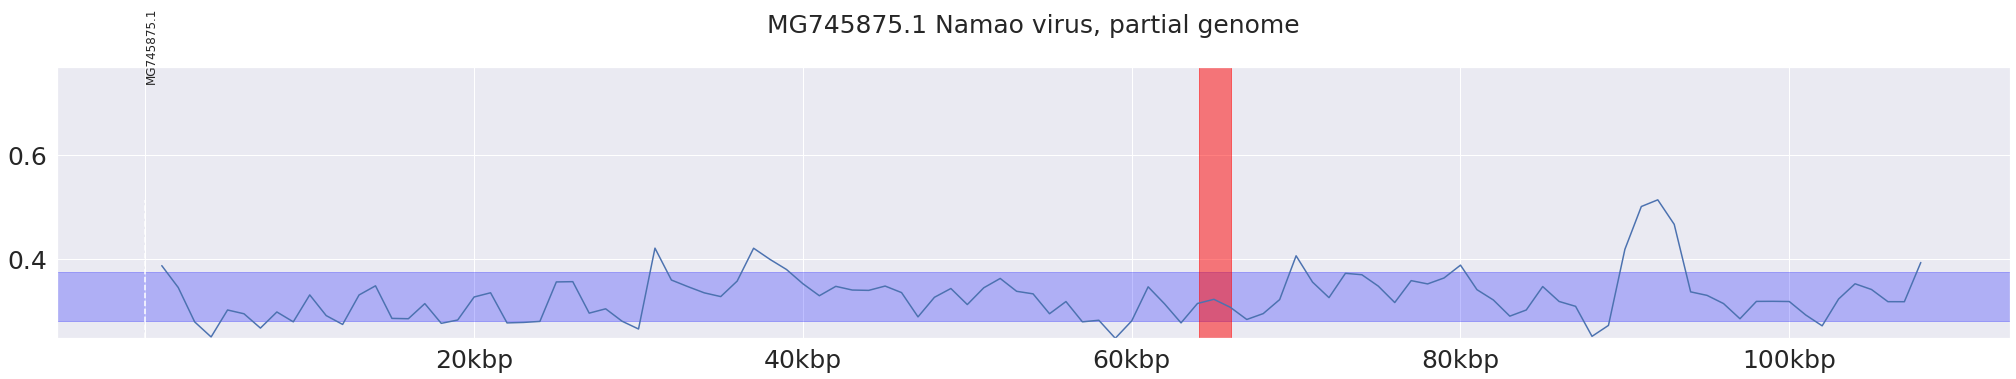

./GCA_003336485.1_ASM333648v1_genomic.fna
QENH01000201.1 Methanophagales archaeon isolate CONS3730B06UFb1 Ga0123266_1001, whole genome shotgun sequence

nan
['', '', '500kbp', '1000kbp', '1500kbp', '2000kbp', '2500kbp', '3000kbp', '3500kbp']
title
QENH01000201.1 Methanophagales archaeon isolate CONS3730B06UFb1 Ga0123266_1001, whole genome shotgun sequence

[(2117839, 2124734)]
(8139, 15034)
[6895]


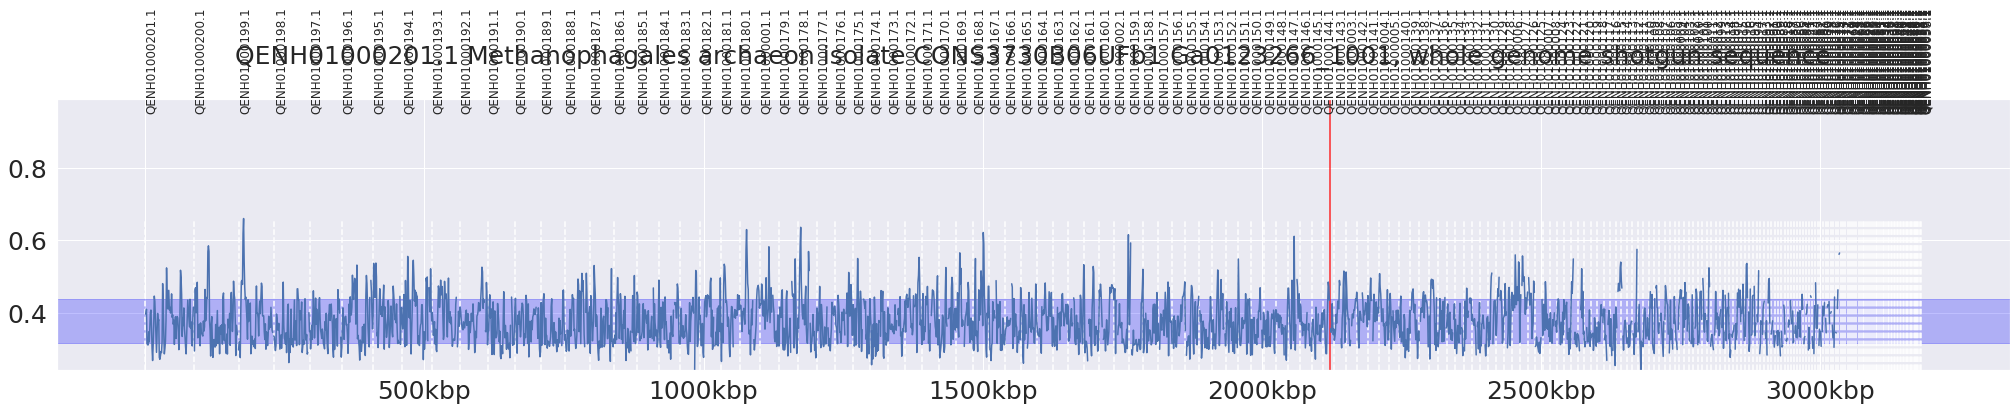

In [52]:

       
#size of window to calculate the spectrum
windowsize = 2000
#step size for moving the window
steplen = 1000
#minimum length of possibly transfered regions to consider
minregionlen = 500


genomes = glob.glob('./*.fna')
genes = glob.glob('./*fasta')

gene_pos={}

for gene in genes:
    with open(gene,'r')as genein:
        firstline = next(genein)
    location = firstline.split()[0]
    print(location)
    positions = [int(l.replace('c','')) for l in location.split(':')[1].split('-')]
    
    contig = location.split(':')[0].replace('>','').replace('NZ_','')
    gene_pos[contig] = positions

weird_regions = {}
gene_regions={}
genechunks={}
transferred_percent ={}


for genome in genomes:

    print(genome)
    with open(genome, 'r')as genomein:
        for l in genomein:
            titleline = l[1:]
            if '>' in l:
                break
        avgspectra = histvec(genomein, kmerindex)
    print(titleline)
    
    titleline = l.replace('>','')
    if titleline in name_map:
        titleline = name_map[titleline]
    
    if str(titleline.split('_')[0].split('-')[0] ) in name_map:
        print('found')
        titleline = name_map[str(titleline.split('_')[0].split('-')[0] )]
    
    
    deviation = [ (count,np.sum(np.absolute(avgspectra-histvec(seq, kmerindex)))) for count,seq in genomechop(genome,windowsize, steplen) ]
    calculated, deviation = zip(*deviation)
    positions, labels ,genomesize  = genometicks( genome )
    
    total = 0
    fig = plt.figure( figsize = (35,5))

    ax = fig.add_subplot(111)
    
    ax.plot(calculated,deviation)  
    pltlabels = [ l for i,l in enumerate(labels)]
    print(np.amax(deviation))
    deviation = np.asarray(deviation)
    maxh= np.amax(deviation[~np.isnan(deviation)])
    minh= np.amin(deviation[~np.isnan(deviation)])
    ax.vlines( positions, minh ,maxh  , colors='white', linestyles='dashed', label=labels)
    
    
    ticks = [ str(int(item/1000))+'kbp' if item>0 else '' for item in ax.get_xticks().tolist()]
    
    print(ticks)
    ax.set_xticklabels(ticks)
    ax.tick_params(labelsize = 25)
    
    
    for p,l in zip(positions,labels):
        ax.annotate( l , (p,maxh+.45*maxh) , rotation = 90  )
    
    ax.set_ylim((minh, maxh+.5*maxh))
    
    print('title')
    print(titleline)
    
    ax.set_title(titleline , fontsize = 25)
    avg = np.nanmean(deviation)
    stdv = np.nanstd(deviation)
    ax.axhspan( avg-stdv , avg+stdv , color ='blue' , alpha = .25)

    stpts = [ i*steplen for i,pt in enumerate(deviation) if i>0 and deviation[i-1]-(avg+stdv) < 0 and deviation[i]-(avg+stdv)>0]
    stopts = [ i*steplen for i,pt in enumerate(deviation) if i>0 and deviation[i-1]-(avg+stdv) > 0 and deviation[i]-(avg+stdv) < 0]
    #split regions that are split by contig limits

    for label in labels:
    #label gene position
        if label in gene_pos:
            #print(label)
            start = min(gene_pos[label])
            stop = max(gene_pos[label])
            offset=positions[labels.index(label)]
            #print(offset)
            ax.axvspan(offset+start,offset+stop, color='red', alpha=0.5)
            #keep all gene regions
            keep =[ ( max(0,offset+start-2500) , offset+stop+ 2500) ]

            for pair in zip(stpts,stopts):
                if offset >= pair[0] and offset<= pair[1]:
                    keep =[ ( pair[0] , pair[1]) ]           

            print(keep)

            gene_regions[genome] = [region for region in genomeslice(genome ,positions, labels, keep , contig= label , verbose = True)]

            print( [len(gr) for gr in gene_regions[genome] ])

    keep= [ pair for pair in zip(stpts,stopts) if pair[1]-pair[0]> minregionlen]

    #weird_regions[genome] = [region for region in genomeslice(genome ,positions, labels, keep , contig= None )]

    #transferred_percent[genome] = sum( [ len(region) for region in weird_regions]) /  genomesize
    plt.savefig(titleline+'.svg')
    plt.show()
    
    

['./GCA_006452135.1_ASM645213v1_genomic.fna', './GCA_006452155.1_ASM645215v1_genomic.fna', './GCA_003336485.1_ASM333648v1_genomic.fna']
./GCA_006452135.1_ASM645213v1_genomic.fna


/home/cactuskid/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


MG745874.1 Namao virus, partial genome

0
(53,)
(53,)
1
(339,)
(339,)
['', '', '25kbp', '50kbp', '75kbp', '100kbp', '125kbp', '150kbp', '175kbp', '200kbp', '225kbp']
title
MG745874.1 Namao virus, partial genome



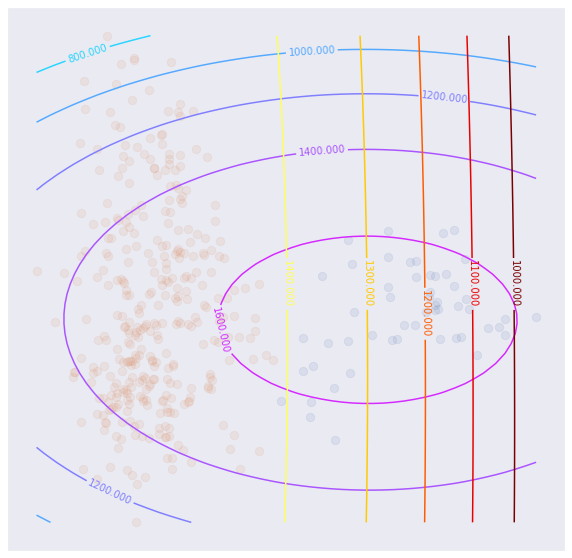

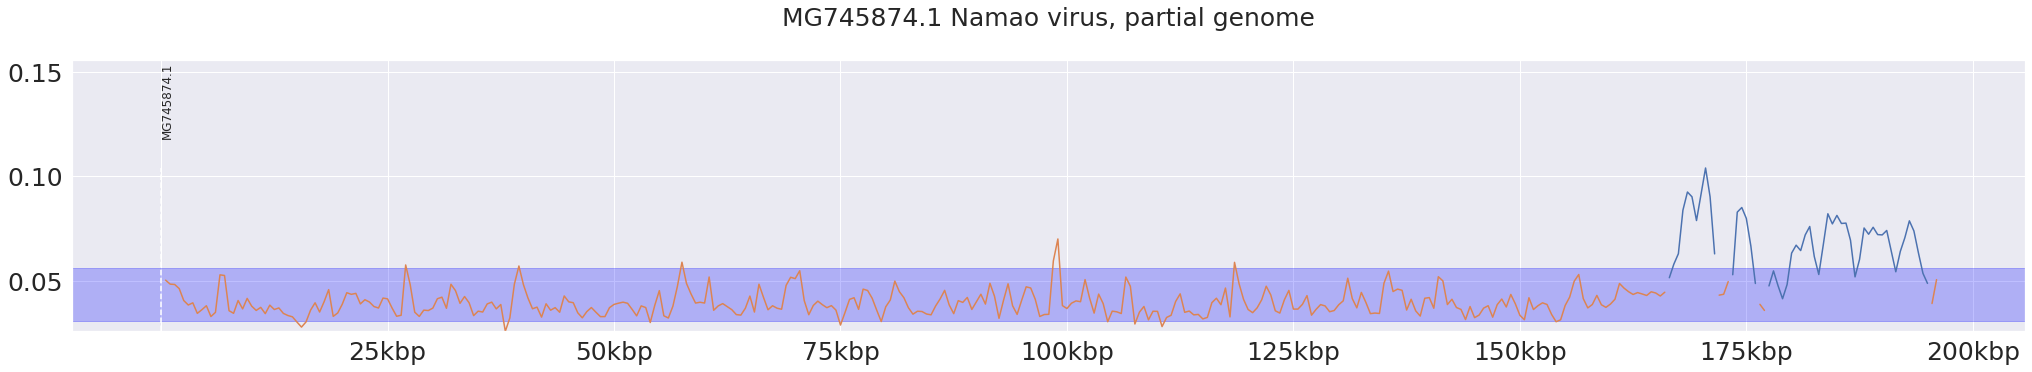

./GCA_006452155.1_ASM645215v1_genomic.fna


/home/cactuskid/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


MG745875.1 Namao virus, partial genome

0
(120,)
(120,)
1
(98,)
(98,)
['', '', '20kbp', '40kbp', '60kbp', '80kbp', '100kbp', '120kbp']
title
MG745875.1 Namao virus, partial genome

1508.42213933076
1056.2574679434124


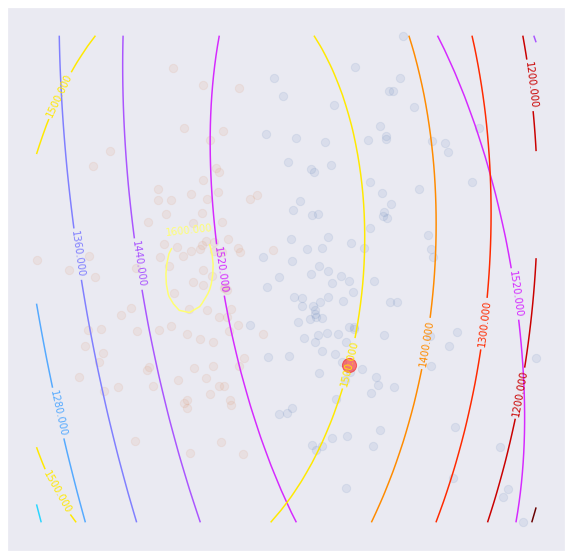

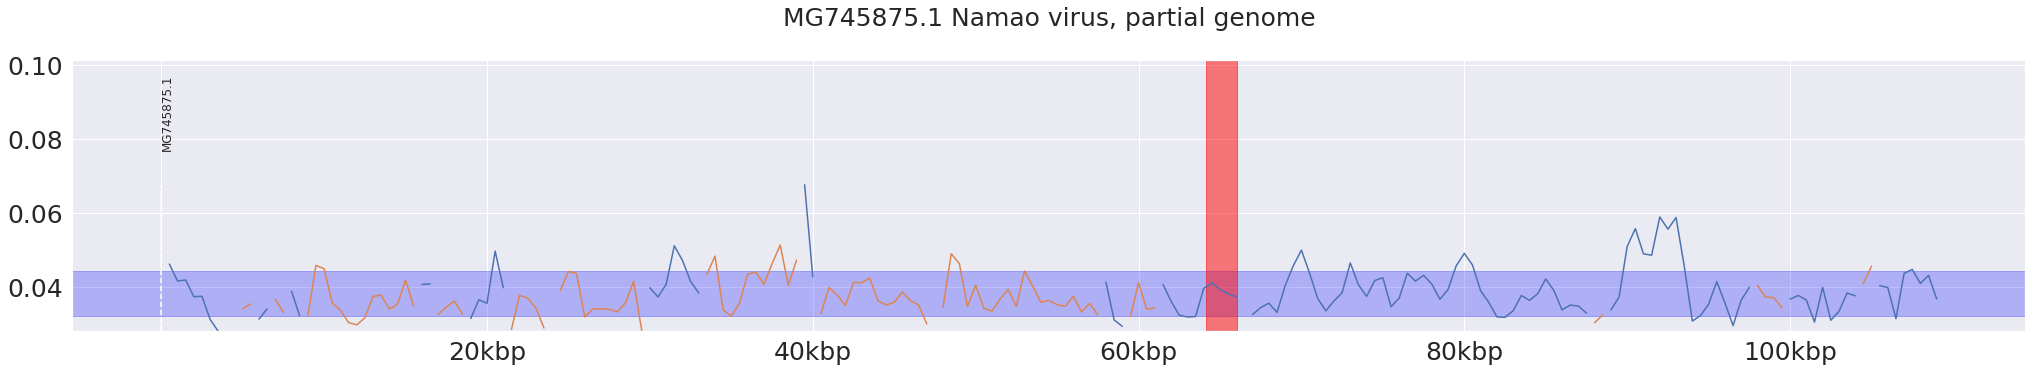

./GCA_003336485.1_ASM333648v1_genomic.fna


/home/cactuskid/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


QENH01000201.1 Methanophagales archaeon isolate CONS3730B06UFb1 Ga0123266_1001, whole genome shotgun sequence

0
(3117,)
(3117,)
1
(2945,)
(2945,)
['', '', '500kbp', '1000kbp', '1500kbp', '2000kbp', '2500kbp', '3000kbp', '3500kbp']
title
QENH01000201.1 Methanophagales archaeon isolate CONS3730B06UFb1 Ga0123266_1001, whole genome shotgun sequence

1312.6226373082447
1329.5723220409345


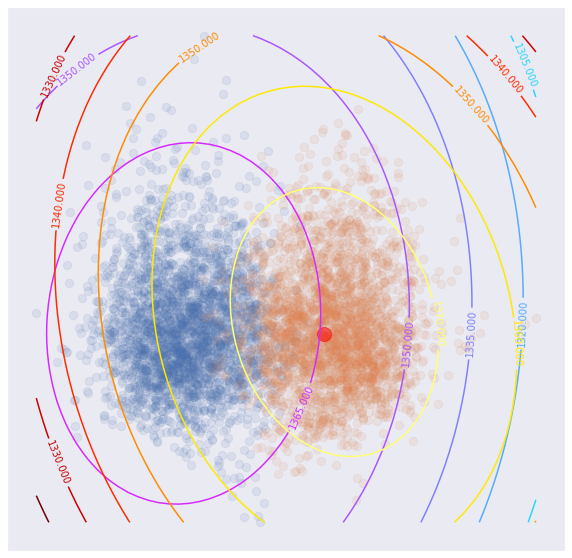

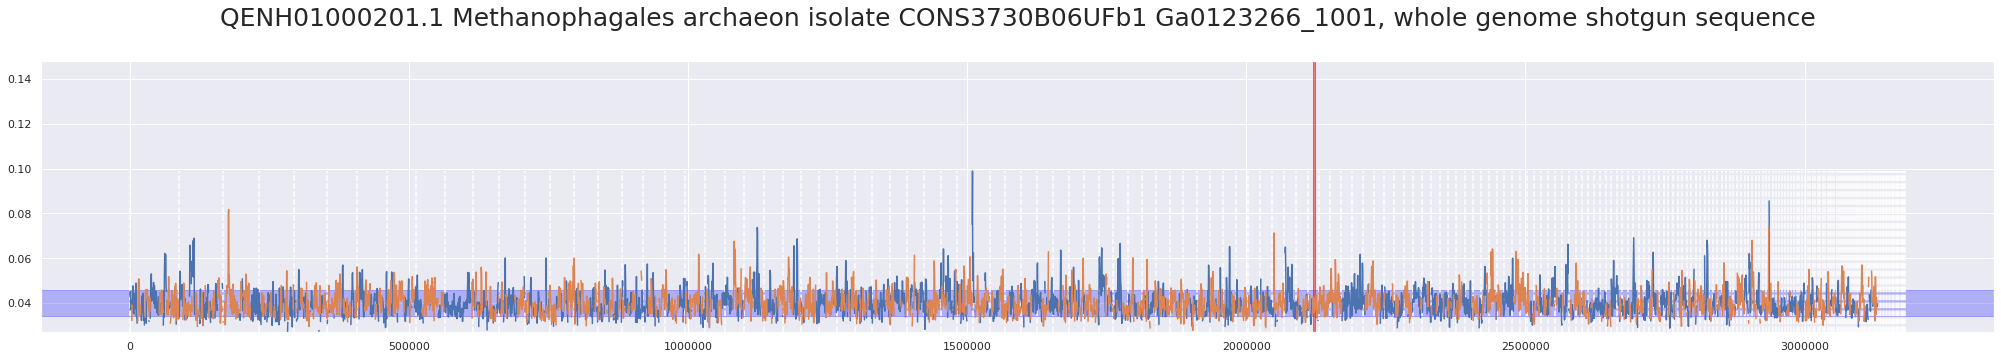

In [51]:
from colour import Color
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn import mixture
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
import glob
import math

##use gaussian mixture models to give pvals to kmer windows in genome. prob not correct if the window size varies... so FsxA's location on these PCA plots is not gospel

#size of window to calculate the spectrum
windowsize = 1000
#step size for moving the window
steplen = 500
#minimum length of possibly transfered regions to consider
minregionlen = 500
genomes = glob.glob('./*.fna')
genes = glob.glob('./*fasta')

gene_pos={}
gene_spectra={}
for gene in genes:
    with open(gene,'r')as genein:
        firstline = next(genein)
        location = firstline.split()[0]
        positions = [int(l.replace('c','')) for l in location.split(':')[1].split('-')]
        contig = location.split(':')[0].replace('>','').replace('NZ_','')
        gene_pos[contig] = positions
        gene_spectra[contig] = histvec(genein, kmerindex)
    
red = Color('red')
blue = Color('blue')
c = list(red.range_to(blue, len(genomes)))
c = [ C.rgb for C in c]

genomes = glob.glob('./*.fna')
print(genomes)
cvec = []
alphavec = []
svec = []
markers =[]
pts = []
allgenomepts = {}
centroids ={}

for i,genome in enumerate(genomes):
    #plt of kmer spectra gaussians

    print(genome)
    with open(genome, 'r')as genomein:
        for l in genomein:
            titleline = l[1:]
            if '>' in l:
                break
        avgspectra = histvec(genomein, kmerindex)

    fig1= plt.figure(figsize=(10,10))
    ax1 = fig1.add_subplot(111)


    positions, labels ,genomesize  = genometicks( genome )

    pca = PCA(n_components=2)
    spectra = [ (count, histvec(seq, kmerindex)) for count,seq in genomechop(genome,windowsize, steplen)]    
    calculated, spectra = zip(*spectra)
    deviation = np.abs([ np.linalg.norm(s - avgspectra) for s in spectra ] )

    calculated = np.asarray(calculated)
    allpts = np.vstack(spectra)

    calculated = calculated[~np.isnan(allpts).any(axis=1)]
    deviation = deviation[~np.isnan(allpts).any(axis=1)]
    allpts = allpts[~np.isnan(allpts).any(axis=1)]

    clf = mixture.BayesianGaussianMixture(n_components=2, covariance_type='full')


    clf.fit(allpts)
    pca.fit(allpts)

    proj_data = pca.transform(allpts)
    x = np.linspace(np.amin(proj_data[:,0]),np.amax(proj_data[:,0]))
    y = np.linspace(np.amin(proj_data[:,1]),np.amax(proj_data[:,1]))
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T

    #project samples to original space
    XX_map = pca.inverse_transform(XX)

    #make a pdf for each gaussian and predict log prob for xxmap
    Z1 = multivariate_normal.logpdf(XX_map, mean= clf.means_[0] , cov= clf.covariances_[0] ).reshape(X.shape)
    Z2 = multivariate_normal.logpdf(XX_map, mean= clf.means_[1] , cov= clf.covariances_[1] ).reshape(X.shape)

    CS1 = ax1.contour(X, Y, Z1 , levels = 5 ,  cmap = 'cool')
    ax1.clabel(CS1, inline=1, fontsize=10 )
    CS2 = ax1.contour(X, Y, Z2 , levels = 5  , cmap = 'hot')
    ax1.clabel(CS2, inline=1, fontsize=10 )
    ax1.set_yticks([])
    ax1.set_xticks([])

    classes =  clf.predict( np.nan_to_num( np.vstack(allpts) ) )
    for c in list(np.unique(classes)):
        ax1.scatter(proj_data[np.where(classes == c), 0], proj_data[np.where(classes == c), 1], s = 70 , alpha = .1 )
    print(titleline)
    titleline = l.replace('>','')
    if titleline in name_map:
        titleline = name_map[titleline]
    if str(titleline.split('_')[0].split('-')[0] ) in name_map:
        print('found')
        titleline = name_map[str(titleline.split('_')[0].split('-')[0] )]

    calculated = np.nan_to_num(np.asarray(calculated))
    deviation = np.nan_to_num(np.asarray(deviation))
    positions, labels ,genomesize  = genometicks( genome )

    total = 0
    plt.savefig(titleline+'mixture.svg')


    fig2 = plt.figure( figsize = (35,5))
    ax2 = fig2.add_subplot(111)
    for c in list(np.unique(classes)):
        print(c)
        deviationsub =  np.empty(deviation.shape)
        deviationsub[:] =  np.nan   
        deviationsub[ np.where(classes == c) ] = deviation[ np.where(classes == c) ]
        print(calculated[ np.where(classes == c) ].shape )
        print( deviation[ np.where(classes == c) ].shape )
        ax2.plot(calculated,deviationsub )#list(deviation[ np.where(classes == c)]) )

    pltlabels = [ l for i,l in enumerate(labels) ]
    deviation = np.asarray( deviation )
    maxh=np.amax( deviation[~np.isnan(deviation)])
    minh=np.amin( deviation[~np.isnan(deviation)])
    ax2.vlines( positions, minh ,maxh  , colors='white', linestyles='dashed', label=labels)


    ticks = [ str(int(math.floor(item/1000)) ) +'kbp' if item>0 else '' for item in ax2.get_xticks().tolist()]
    print(ticks)

    if len(positions) < 40:
        ax2.set_xticklabels(ticks)
        ax2.tick_params(labelsize = 25)

        for p,l in zip(positions,labels):
            ax2.annotate( l , (p,maxh+.15*maxh) , rotation = 90  )


    ax2.set_ylim((minh, maxh+.5*maxh))
    print('title')
    print(titleline)
    ax2.set_title(titleline , fontsize = 25)
    avg = np.nanmean(deviation)
    stdv = np.nanstd(deviation)
    ax2.axhspan( avg-stdv , avg+stdv , color ='blue' , alpha = .25)
    stpts = [ i*steplen for i,pt in enumerate(deviation) if i>0 and deviation[i-1]-(avg+stdv) < 0 and deviation[i]-(avg+stdv)>0]
    stopts = [ i*steplen for i,pt in enumerate(deviation) if i>0 and deviation[i-1]-(avg+stdv) > 0 and deviation[i]-(avg+stdv) < 0]
    #split regions that are split by contig limits

    for label in labels:
    #label gene position
        if label in gene_pos:
            try:
                start = min(gene_pos[label])
                stop = max(gene_pos[label])
                spectrum = gene_spectra[label]
                spectrum = spectrum[ ~np.isnan(spectrum) ]

                Z1 = multivariate_normal.logpdf(spectrum, mean= clf.means_[0] , cov= clf.covariances_[0] )
                Z2 = multivariate_normal.logpdf(spectrum, mean= clf.means_[1] , cov= clf.covariances_[1] )
                print(Z1)
                print(Z2)

                spectrum = gene_spectra[label]
                spectrum = spectrum[ ~np.isnan(spectrum)]
                genepca = pca.transform(spectrum.reshape(1, -1))
                ax1.scatter( genepca[:,0] ,  genepca[:,1], s = 200 , c = 'red' , alpha = .5  )

                offset=positions[labels.index(label)]
                ax2.axvspan(offset+start,offset+stop, color='red', alpha=0.5)

                #keep all gene regions
                #keep =[ ( max(0,offset+start-2500) , offset+stop+ 2500) ]
                #output proba of fsxa and centroid                
                keep =[ ( max(0,offset+start-2500) , offset+stop+ 2500) ]
                #print(multivariate_normal.logpdf(fsxa , mean= clf.means_[0] , cov= clf.covariances_[0] ))
                #print(multivariate_normal.logpdf(fsxa , mean= clf.means_[1] , cov= clf.covariances_[1] ))
            except:
                print(label)
    plt.savefig(titleline+'.svg')

    plt.show()
